# Dataset Structured Description

## 1. Overview
- Dataset comes from **Vesta’s real-world fraud detection system**, anonymized for privacy.  
- Two main tables:  
  - **Transaction Table** (core features about transactions)  
  - **Identity Table** (network, device, and digital fingerprint features)  
- Target variable: `isFraud`  
  - `1` = reported fraud (chargeback + linked transactions)  
  - `0` = legitimate transaction  


## 2. Transaction Table

### Core Features
- **TransactionDT**  
  - Timedelta in seconds from a reference point (not actual timestamp).  
  - First value = 86,400 (one day).  
  - Maximum ~15,811,131 → ~183 days (~6 months).  

- **TransactionAMT**  
  - Payment amount in USD.  
  - Sometimes 3 decimal places → may indicate currency conversion.  

- **ProductCD**  
  - Product/service code (not necessarily physical product).  

- **card1–card6**  
  - Payment card information (type, category, issuer, country, etc.).  

- **addr1, addr2**  
  - Address fields:  
    - `addr1` = billing region  
    - `addr2` = billing country  

- **dist**  
  - Distance measure (between billing, mailing, IP, phone area, etc.).  

- **P_emaildomain / R_emaildomain**  
  - Purchaser and recipient email domains.  
  - `R_emaildomain` often null (no recipient needed).  

### Engineered / Aggregated Features
- **C1–C14**  
  - Counting features (e.g., number of devices, IPs, phone numbers, billing addresses linked to a card).  

- **D1–D15**  
  - Timedeltas (e.g., days since last transaction, days between events).  

- **M1–M9**  
  - Match flags (e.g., whether name on card matches billing address).  

- **Vxxx (V1–V339)**  
  - Rich engineered features by Vesta: ranking, counting, entity relationships (e.g., frequency of card + IP + email within 24h).  
  - All numerical (should not be treated as categorical).  

### Categorical Features
- ProductCD  
- card1–card6  
- addr1, addr2  
- P_emaildomain, R_emaildomain  
- M1–M9  

---

## 3. Identity Table

### Description
- Contains **identity and device-level features**, e.g.:  
  - Network information (IP, ISP, proxy)  
  - Device/browser/OS/user-agent fingerprints  
  - Digital signatures  
- Fields are masked; no dictionary provided (for privacy & contracts).  

### Key Fields
- **DeviceType** (e.g., mobile/desktop).  
- **DeviceInfo** (specific device string).  
- **id_01–id_11**: numerical ratings/behavioral signals.  
- **id_12–id_38**: Mix of categorical & numerical (IP/domain rating, proxy rating, login failures, behavioral patterns like session duration).  

### Categorical Features
- DeviceType  
- DeviceInfo  
- id_12–id_38  

---

## 4. Labeling Logic
- **Fraud (`isFraud = 1`)**:  
  - Reported chargebacks.  
  - Plus subsequent linked transactions (same card/account/email/billing address within 120 days).  

- **Legit (`isFraud = 0`)**:  
  - If not reported within 120 days, treated as legitimate.  

- **Caveat**: Some fraud may remain unlabeled (e.g., cardholder unaware or reported too late). These are considered rare and negligible.  

---

## 5. Important Observations & Comments
- **Transaction types**: Include money transfers, goods, services, even tickets booked for others.  
- **TransactionAMT quirks**: Decimal precision linked with missing `addr` fields → possibly foreign/converted transactions.  
- **dist feature**: Could encode various distance measures; interpret carefully.  
- **V features**: Powerful but opaque; derived counts/rankings over time, across entities.  
- **Identity features**: Not fully interpretable due to anonymization but useful as fraud signals.  
- **Imbalance**: Fraud cases ~3.5% of total transactions.  


# EDA

## 1. Setup & Data Loading
- Import libraries (pandas, numpy, matplotlib, seaborn, etc.)
- Load **Transaction Table** and **Identity Table**
- Merge them on `TransactionID`
- Display dataset shape and first few rows

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_folder = 'ieee-fraud-detection-data/'

train_identity = pd.read_csv(f'{data_folder}train_identity.csv')
train_transaction = pd.read_csv(f'{data_folder}train_transaction.csv')
test_identity = pd.read_csv(f'{data_folder}test_identity.csv')
test_transaction = pd.read_csv(f'{data_folder}test_transaction.csv')
# let's combine the data and work with the whole dataset
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

In [3]:
print(f'Train dataset has {train.shape[0]} rows and {train.shape[1]} columns.')
print(f'Test dataset has {test.shape[0]} rows and {test.shape[1]} columns.')

Train dataset has 590540 rows and 434 columns.
Test dataset has 506691 rows and 433 columns.


In [4]:
train_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [5]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
del train_identity, train_transaction, test_identity, test_transaction

## 2. Target Variable Analysis


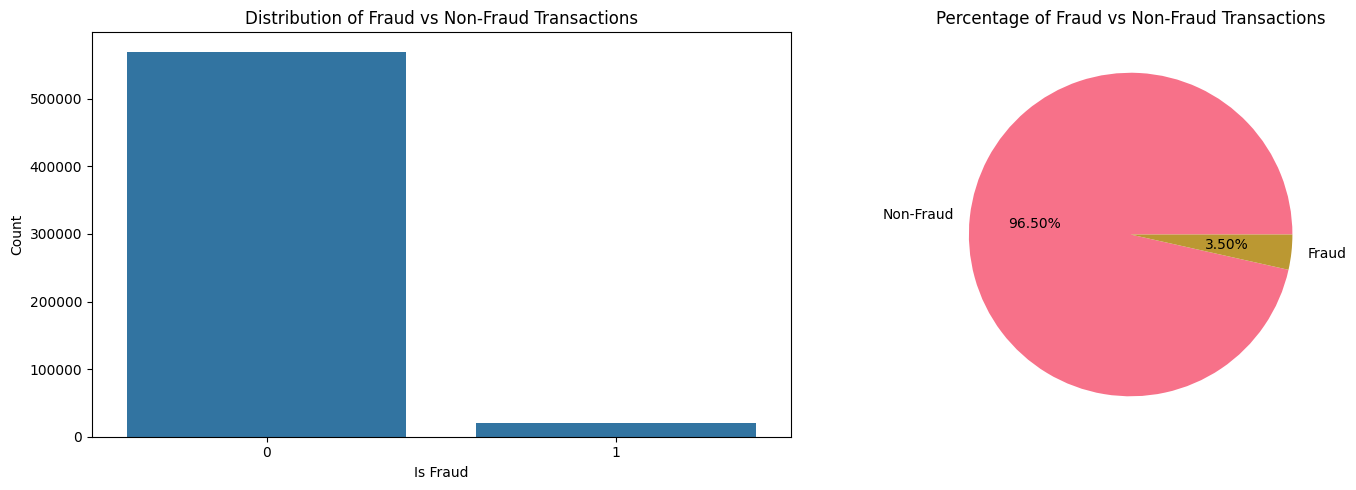


Detailed Statistics:
Total Transactions: 590,540
Fraud Transactions: 20,663
Non-Fraud Transactions: 569,877

Fraud Rate: 3.50%


In [7]:
# Calculate fraud distribution
fraud_dist = train['isFraud'].value_counts()
fraud_pct = train['isFraud'].value_counts(normalize=True) * 100

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Bar chart
sns.barplot(x=fraud_dist.index, y=fraud_dist.values, ax=ax1)
ax1.set_title('Distribution of Fraud vs Non-Fraud Transactions')
ax1.set_xlabel('Is Fraud')
ax1.set_ylabel('Count')

# Plot 2: Pie chart
colors = sns.color_palette('husl')[:2]
ax2.pie(fraud_pct, labels=['Non-Fraud', 'Fraud'], autopct='%1.2f%%', colors=colors)
ax2.set_title('Percentage of Fraud vs Non-Fraud Transactions')

plt.tight_layout()
plt.show()

print("\nDetailed Statistics:")
print(f"Total Transactions: {len(train):,}")
print(f"Fraud Transactions: {fraud_dist[1]:,}")
print(f"Non-Fraud Transactions: {fraud_dist[0]:,}")
print(f"\nFraud Rate: {fraud_pct[1]:.2f}%")

## 3. Missing Values

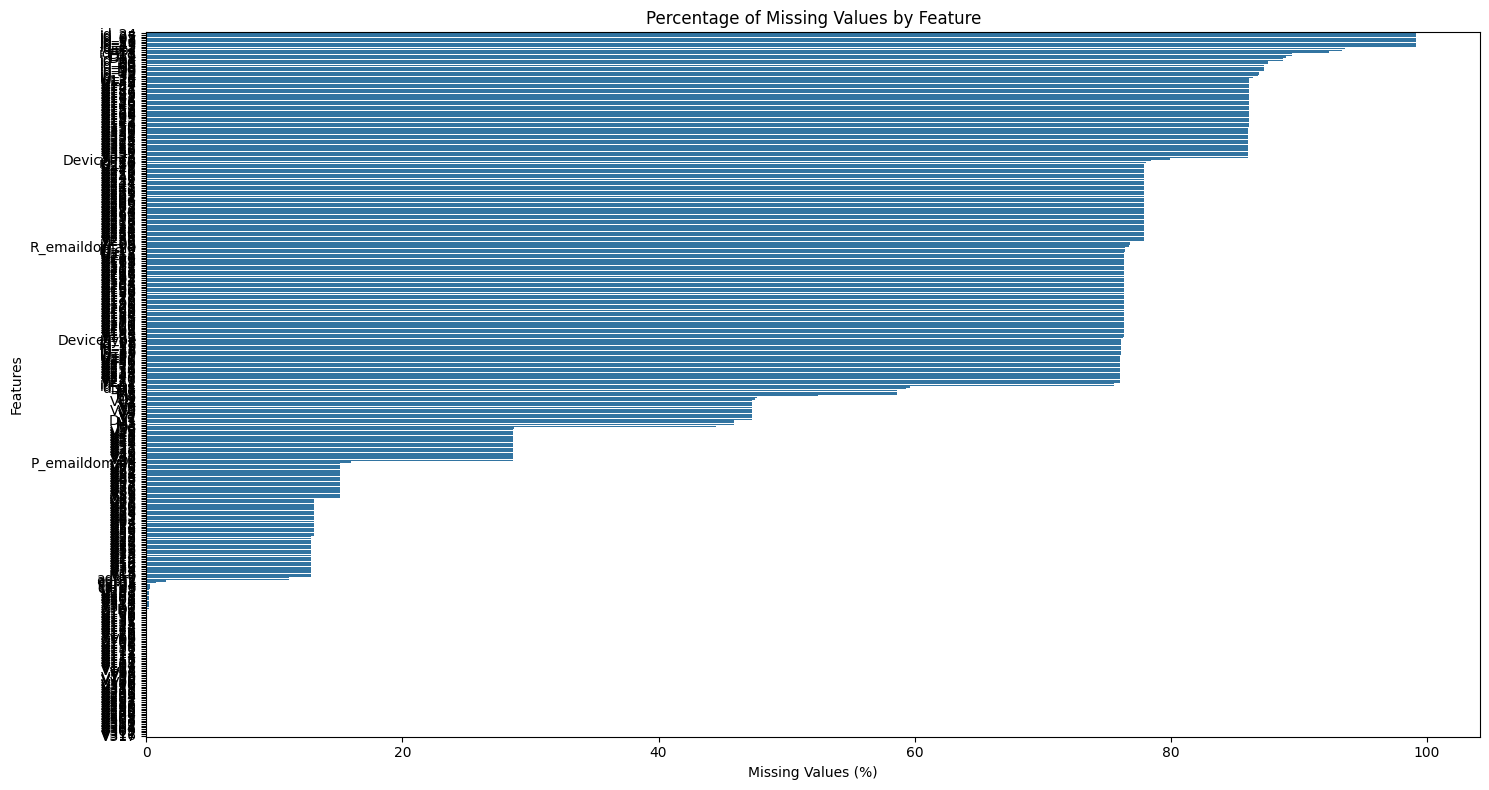


Features with more than 50% missing values:
id_24            99.196159
id_25            99.130965
id_07            99.127070
id_08            99.127070
id_21            99.126393
id_26            99.125715
id_27            99.124699
id_23            99.124699
id_22            99.124699
dist2            93.628374
D7               93.409930
id_18            92.360721
D13              89.509263
D14              89.469469
D12              89.041047
id_04            88.768923
id_03            88.768923
D6               87.606767
id_33            87.589494
id_09            87.312290
D8               87.312290
id_10            87.312290
D9               87.312290
id_30            86.865411
id_32            86.861855
id_34            86.824771
id_14            86.445626
V138             86.123717
V139             86.123717
V148             86.123717
V154             86.123717
V162             86.123717
V141             86.123717
V157             86.123717
V146             86.123717
V163      

In [8]:
# Calculate missing values percentage for each column
missing_values = (train.isnull().sum() / len(train) * 100).sort_values(ascending=False)
missing_values = missing_values[missing_values > 0]  # Only keep columns with missing values

# Create a figure for missing values visualization
plt.figure(figsize=(15, 8))
sns.barplot(x=missing_values.values, y=missing_values.index)
plt.title('Percentage of Missing Values by Feature')
plt.xlabel('Missing Values (%)')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

# Display features with high missingness (>50%)
print("\nFeatures with more than 50% missing values:")
print(missing_values[missing_values > 50].to_string())

# Display features with moderate missingness (20-50%)
print("\nFeatures with 20-50% missing values:")
print(missing_values[(missing_values > 20) & (missing_values <= 50)].to_string())

We see a lot of features with high percentage of missing values. That beeing said, we dont drop those features, because missingness of a feature might be an important indicator of fraud.

## 4. TransactionDT (Time)

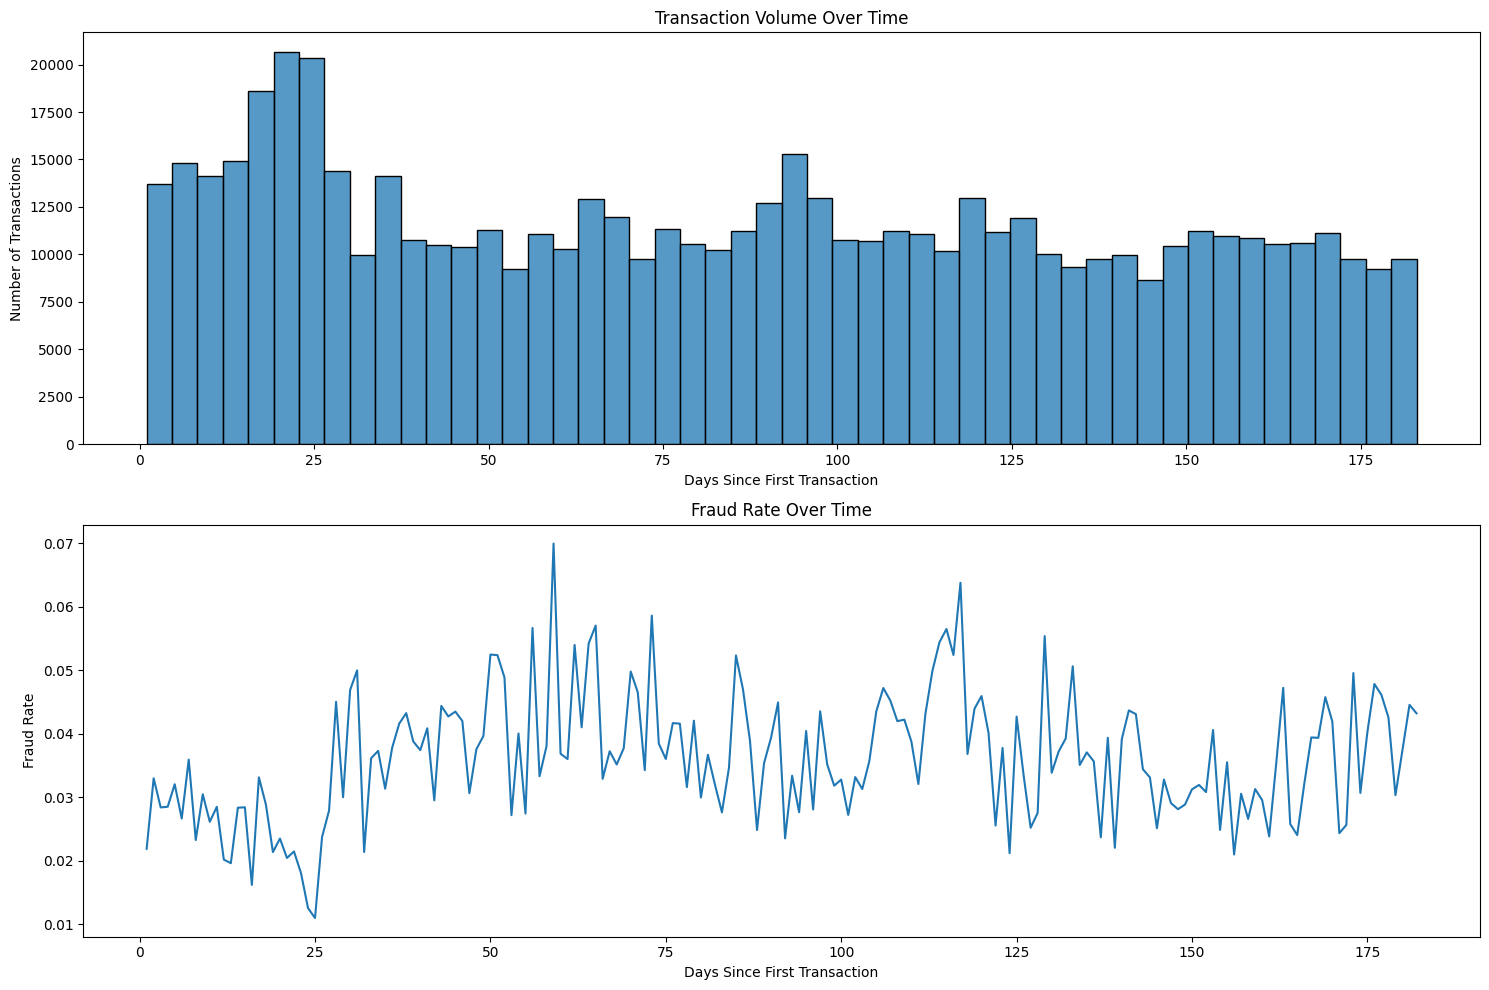


Time-based Statistics:
Total time span: 182.0 days
Average daily transactions: 3244.7

Fraud Rate Statistics:
Minimum daily fraud rate: 1.097%
Maximum daily fraud rate: 6.994%
Average daily fraud rate: 3.605%


In [9]:
# Convert TransactionDT to days
train['TransactionDay'] = train['TransactionDT'] / (24*60*60)

# Create time-based visualizations
plt.figure(figsize=(15, 10))

# Plot 1: Transaction volume over time
plt.subplot(2, 1, 1)
sns.histplot(data=train, x='TransactionDay', bins=50)
plt.title('Transaction Volume Over Time')
plt.xlabel('Days Since First Transaction')
plt.ylabel('Number of Transactions')

# Plot 2: Fraud rate over time
plt.subplot(2, 1, 2)
fraud_rate = train.groupby(train['TransactionDay'].astype(int))['isFraud'].mean()
plt.plot(fraud_rate.index, fraud_rate.values)
plt.title('Fraud Rate Over Time')
plt.xlabel('Days Since First Transaction')
plt.ylabel('Fraud Rate')

plt.tight_layout()
plt.show()

# Print some statistics
print("\nTime-based Statistics:")
print(f"Total time span: {train['TransactionDay'].max()-train['TransactionDay'].min():.1f} days")
print(f"Average daily transactions: {len(train)/len(fraud_rate):.1f}")
print("\nFraud Rate Statistics:")
print(f"Minimum daily fraud rate: {fraud_rate.min():.3%}")
print(f"Maximum daily fraud rate: {fraud_rate.max():.3%}")
print(f"Average daily fraud rate: {fraud_rate.mean():.3%}")

## 5. TransactionAMT


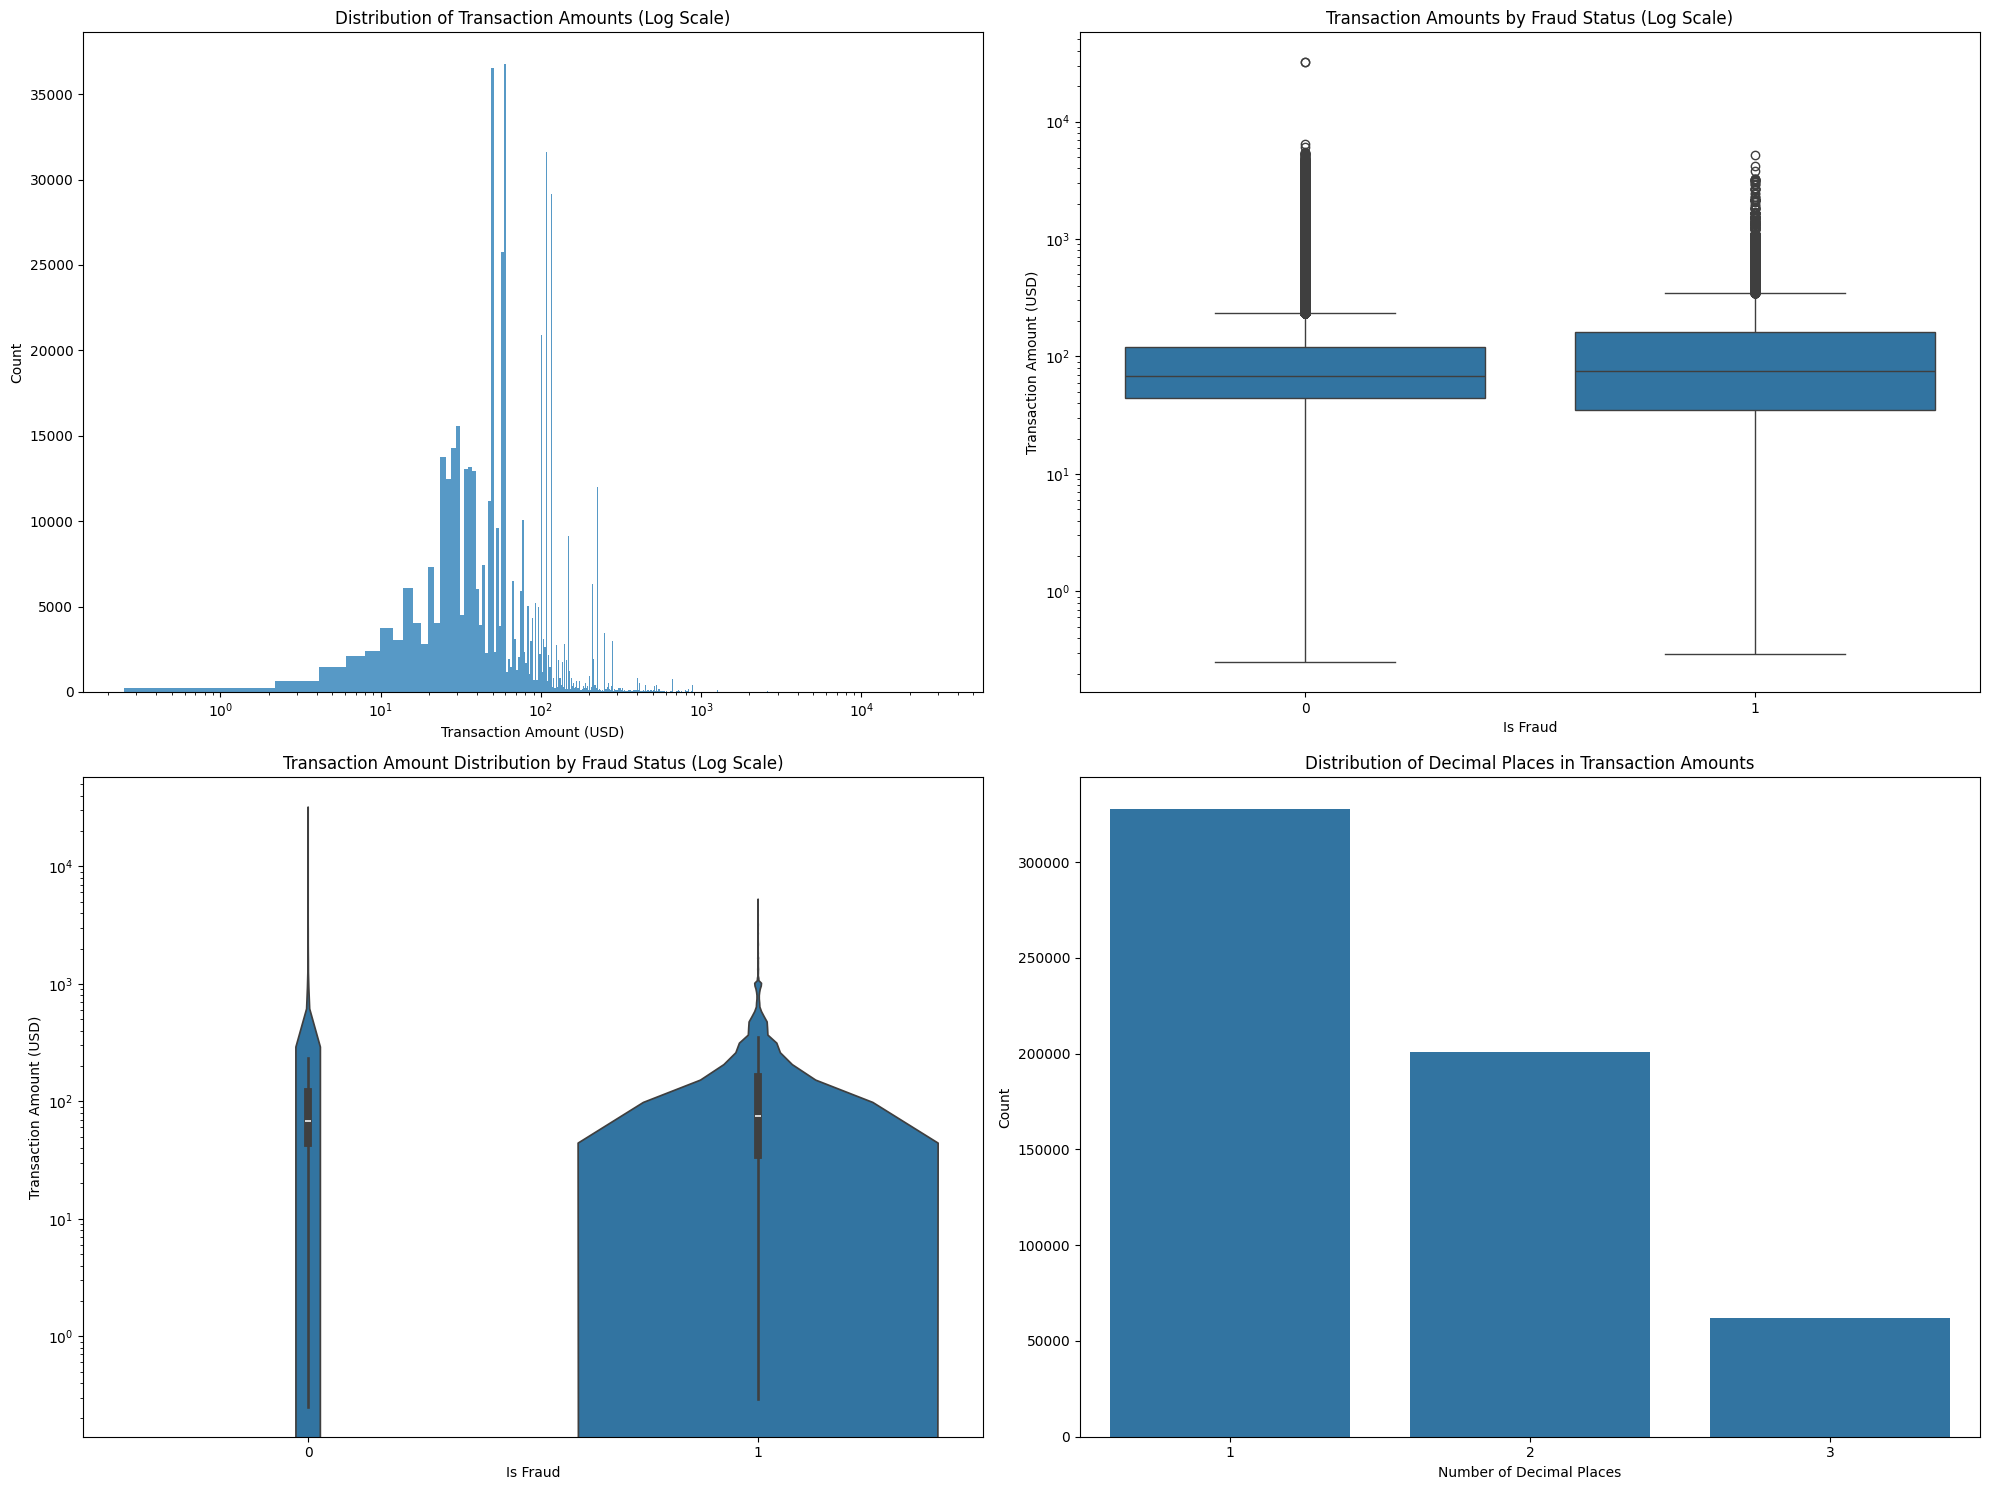


Transaction Amount Statistics:
Minimum amount: $0.25
Maximum amount: $31937.39
Mean amount: $135.03
Median amount: $68.77

Fraud Rate by Transaction Amount Quartile:
TransactionAmt
Q1    0.042428
Q2    0.025090
Q3    0.028252
Q4    0.044388


C:\Users\ppapa\AppData\Local\Temp\ipykernel_12028\259498423.py:44: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_by_amount = train.groupby(amount_quartiles)['isFraud'].mean()


In [10]:
# Create visualizations for TransactionAMT
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))

# Plot 1: Distribution of transaction amounts (log scale)
sns.histplot(data=train, x='TransactionAmt', ax=ax1)
ax1.set_xscale('log')
ax1.set_title('Distribution of Transaction Amounts (Log Scale)')
ax1.set_xlabel('Transaction Amount (USD)')
ax1.set_ylabel('Count')

# Plot 2: Box plot of amounts by fraud status
sns.boxplot(data=train, x='isFraud', y='TransactionAmt', ax=ax2)
ax2.set_yscale('log')
ax2.set_title('Transaction Amounts by Fraud Status (Log Scale)')
ax2.set_xlabel('Is Fraud')
ax2.set_ylabel('Transaction Amount (USD)')

# Plot 3: Violin plot of amounts by fraud status
sns.violinplot(data=train, x='isFraud', y='TransactionAmt', ax=ax3)
ax3.set_yscale('log')
ax3.set_title('Transaction Amount Distribution by Fraud Status (Log Scale)')
ax3.set_xlabel('Is Fraud')
ax3.set_ylabel('Transaction Amount (USD)')

# Plot 4: Analysis of decimal places
train['DecimalPlaces'] = train['TransactionAmt'].apply(lambda x: len(str(x).split('.')[-1]) if '.' in str(x) else 0)
sns.countplot(data=train, x='DecimalPlaces', ax=ax4)
ax4.set_title('Distribution of Decimal Places in Transaction Amounts')
ax4.set_xlabel('Number of Decimal Places')
ax4.set_ylabel('Count')

plt.tight_layout()
plt.show()

# Print statistics about transaction amounts
print("\nTransaction Amount Statistics:")
print(f"Minimum amount: ${train['TransactionAmt'].min():.2f}")
print(f"Maximum amount: ${train['TransactionAmt'].max():.2f}")
print(f"Mean amount: ${train['TransactionAmt'].mean():.2f}")
print(f"Median amount: ${train['TransactionAmt'].median():.2f}")

# Calculate fraud rate by transaction amount quartiles
amount_quartiles = pd.qcut(train['TransactionAmt'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
fraud_by_amount = train.groupby(amount_quartiles)['isFraud'].mean()

print("\nFraud Rate by Transaction Amount Quartile:")
print(fraud_by_amount.to_string())


## 6. Categorical Features
- **ProductCD, card1–card6, addr1/addr2, email domains, M1–M9**
- For each categorical:
  - Top 10 most frequent categories
  - Fraud rate by category
- Group rare categories (long tail handling)


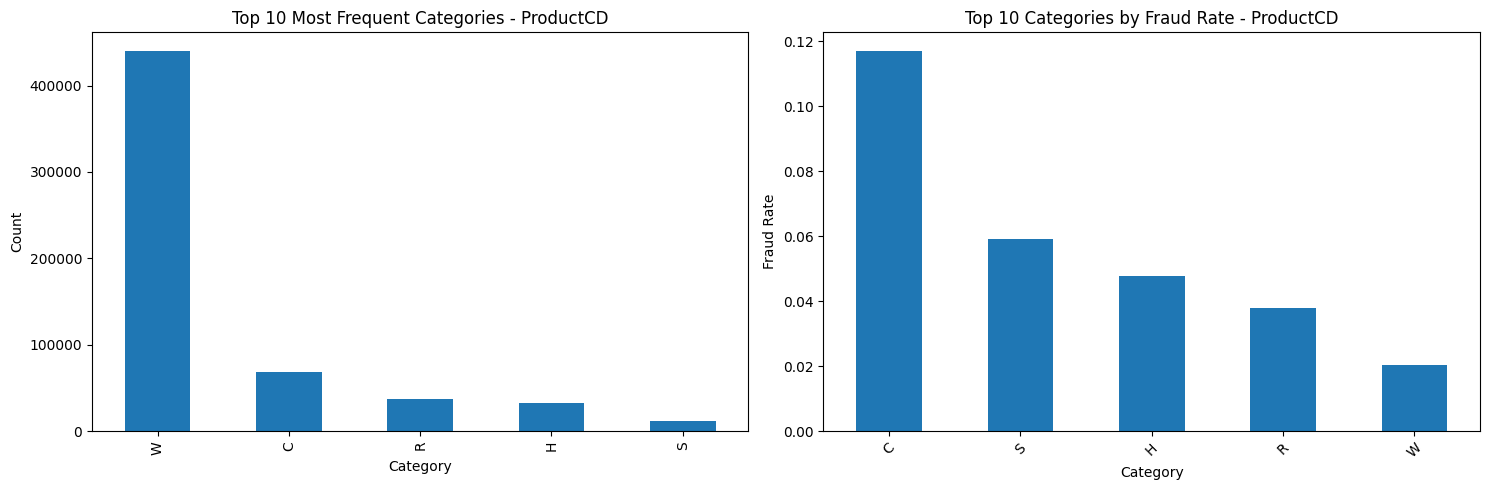


Analysis for ProductCD:
Number of unique values: 5
Missing values: 0 (0.00%)

Top 5 categories by frequency:
ProductCD
W    439670
C     68519
R     37699
H     33024
S     11628

Top 5 categories by fraud rate (min 100 transactions):




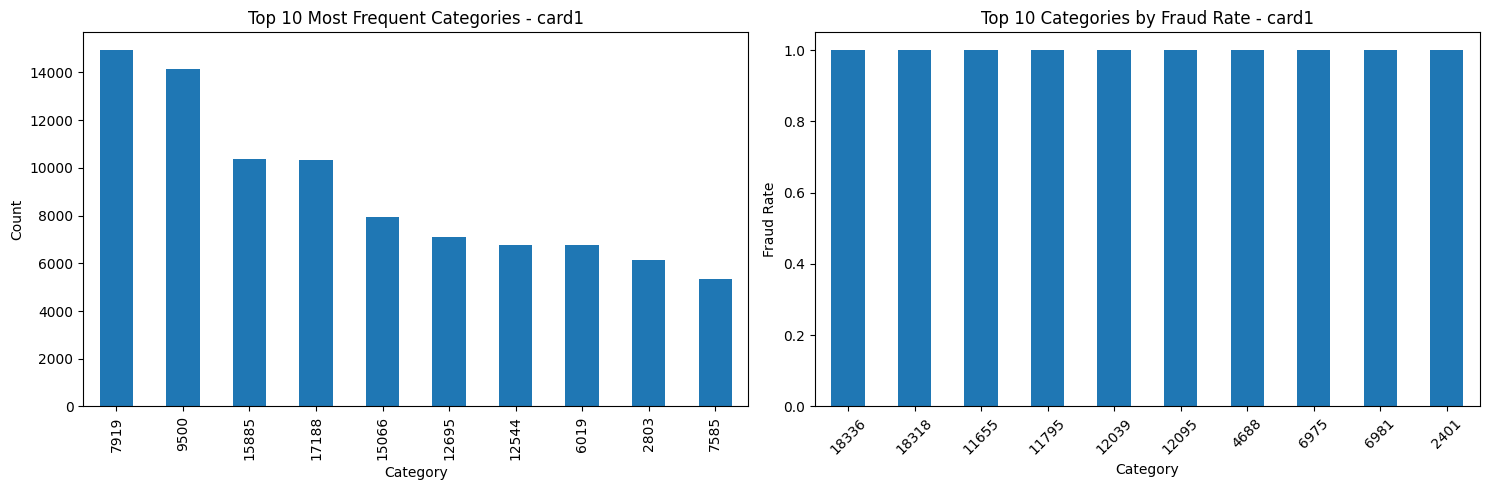


Analysis for card1:
Number of unique values: 13553
Missing values: 0 (0.00%)

Top 5 categories by frequency:
card1
7919     14932
9500     14162
15885    10361
17188    10344
15066     7945

Top 5 categories by fraud rate (min 100 transactions):




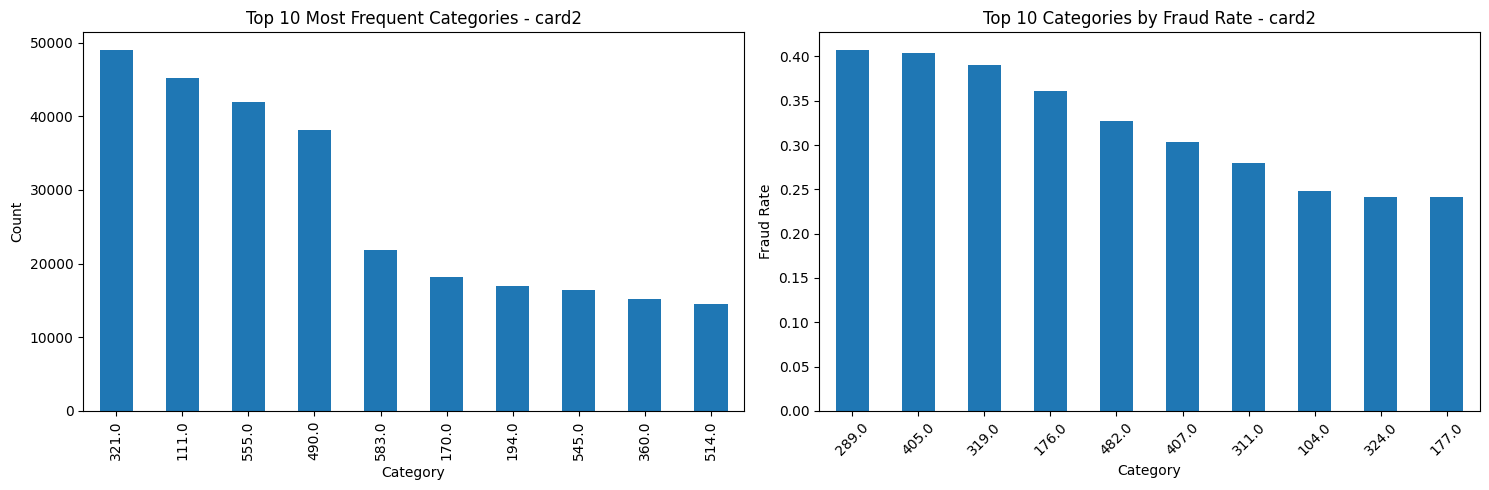


Analysis for card2:
Number of unique values: 500
Missing values: 8933 (1.51%)

Top 5 categories by frequency:
card2
321.0    48935
111.0    45191
555.0    41995
490.0    38145
583.0    21803

Top 5 categories by fraud rate (min 100 transactions):




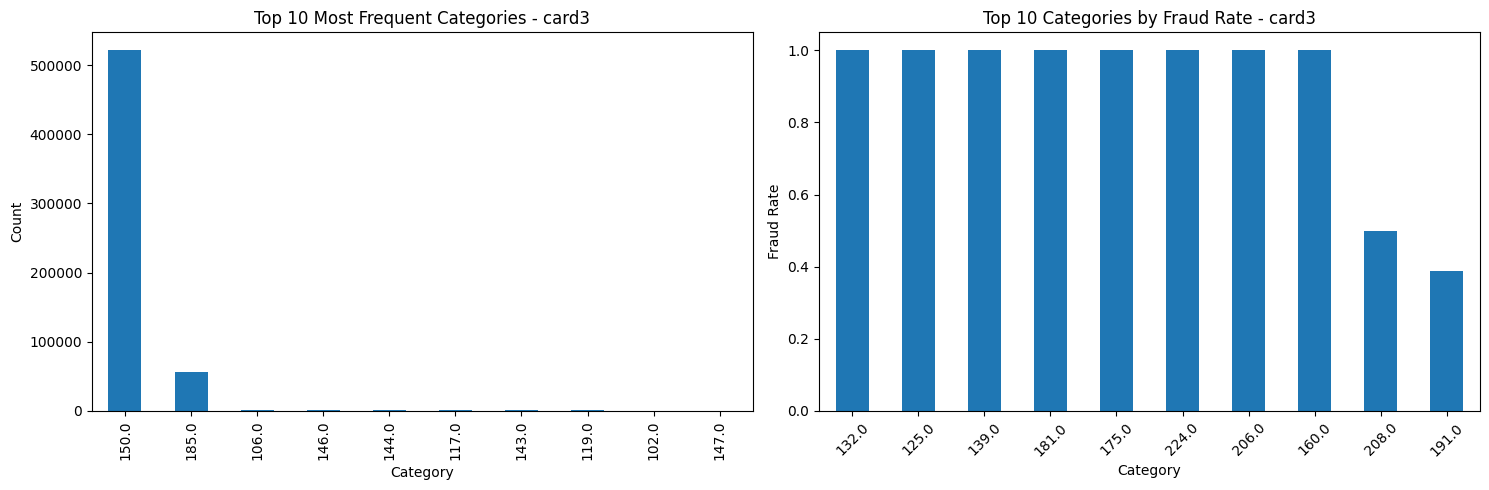


Analysis for card3:
Number of unique values: 114
Missing values: 1565 (0.27%)

Top 5 categories by frequency:
card3
150.0    521287
185.0     56346
106.0      1571
146.0      1252
144.0      1252

Top 5 categories by fraud rate (min 100 transactions):




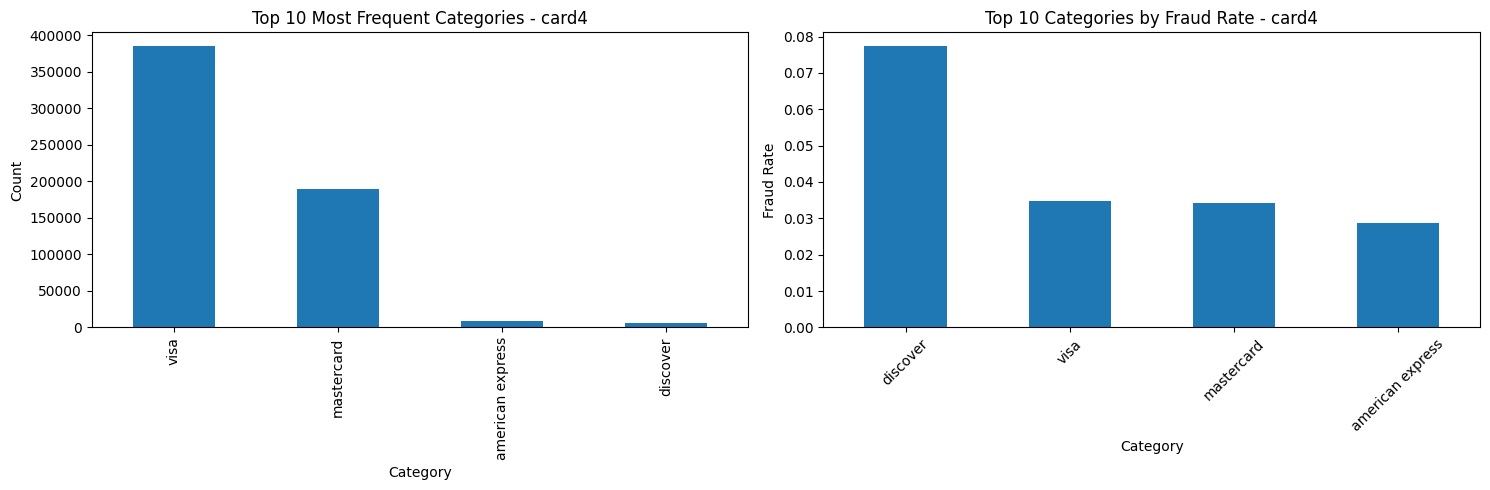


Analysis for card4:
Number of unique values: 4
Missing values: 1577 (0.27%)

Top 5 categories by frequency:
card4
visa                384767
mastercard          189217
american express      8328
discover              6651

Top 5 categories by fraud rate (min 100 transactions):




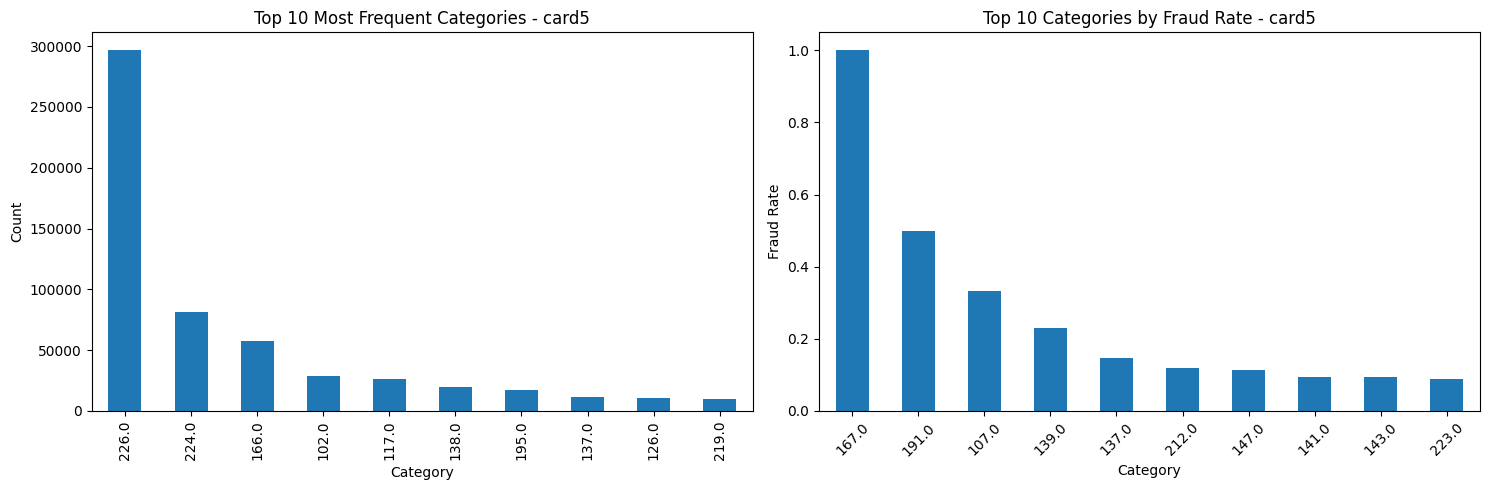


Analysis for card5:
Number of unique values: 119
Missing values: 4259 (0.72%)

Top 5 categories by frequency:
card5
226.0    296546
224.0     81513
166.0     57140
102.0     29105
117.0     25941

Top 5 categories by fraud rate (min 100 transactions):




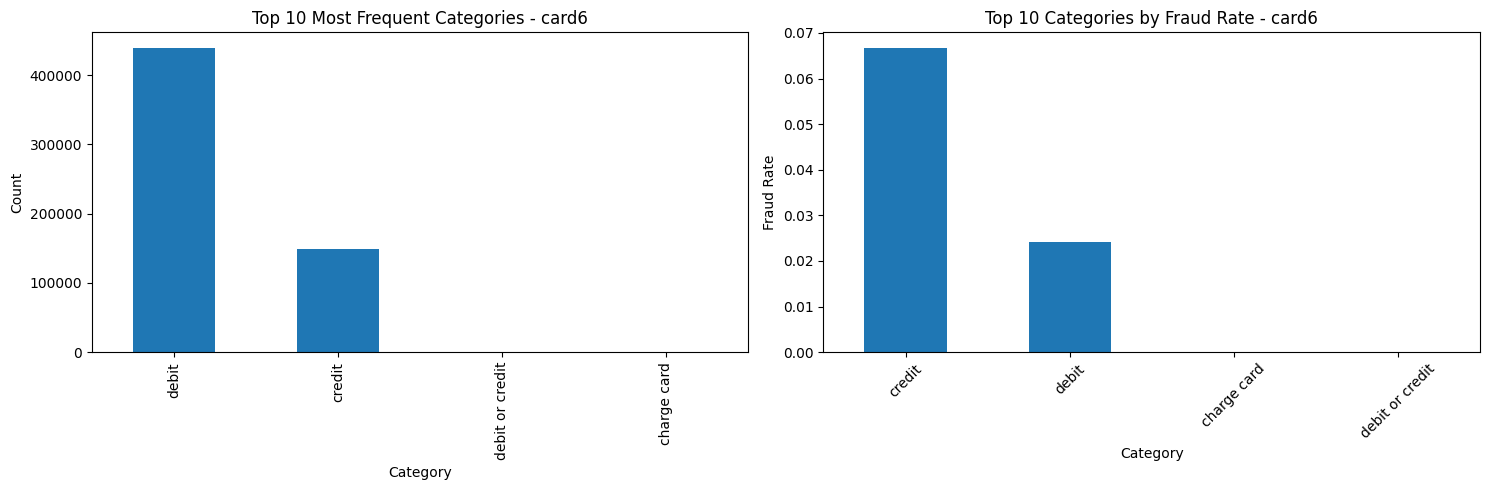


Analysis for card6:
Number of unique values: 4
Missing values: 1571 (0.27%)

Top 5 categories by frequency:
card6
debit              439938
credit             148986
debit or credit        30
charge card            15

Top 5 categories by fraud rate (min 100 transactions):




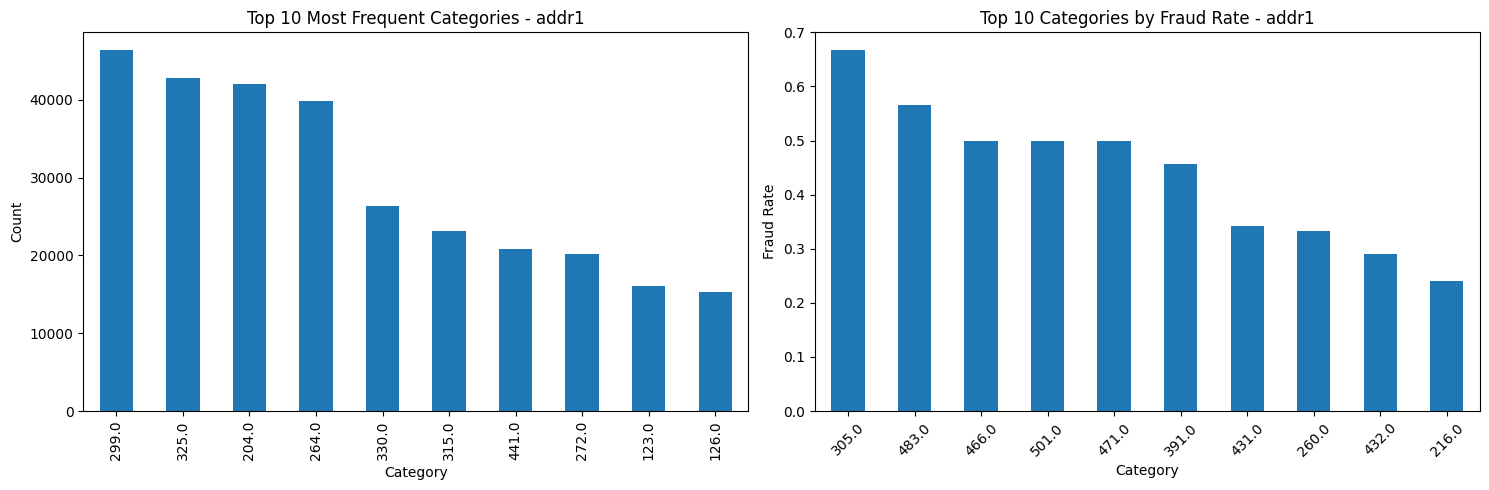


Analysis for addr1:
Number of unique values: 332
Missing values: 65706 (11.13%)

Top 5 categories by frequency:
addr1
299.0    46335
325.0    42751
204.0    42020
264.0    39870
330.0    26287

Top 5 categories by fraud rate (min 100 transactions):




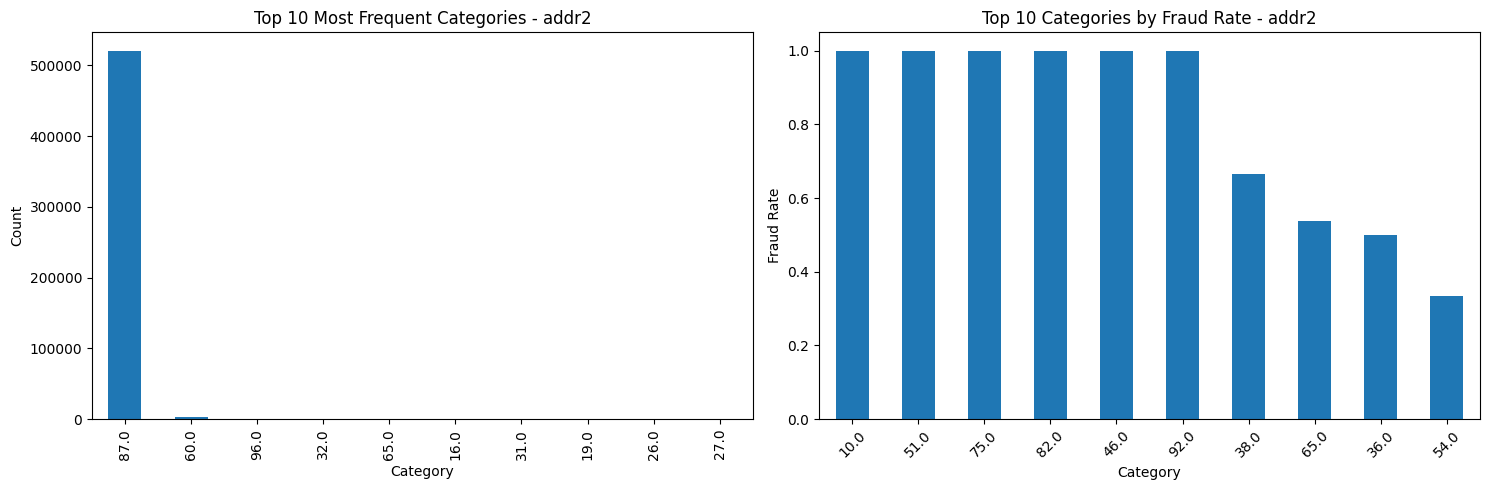


Analysis for addr2:
Number of unique values: 74
Missing values: 65706 (11.13%)

Top 5 categories by frequency:
addr2
87.0    520481
60.0      3084
96.0       638
32.0        91
65.0        82

Top 5 categories by fraud rate (min 100 transactions):




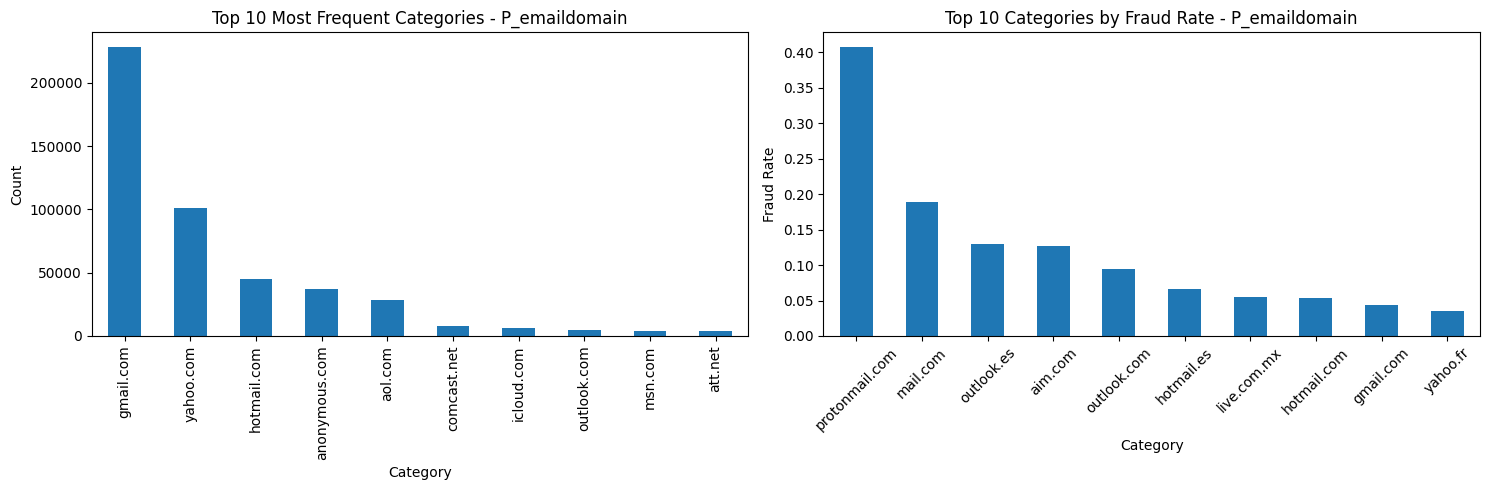


Analysis for P_emaildomain:
Number of unique values: 59
Missing values: 94456 (15.99%)

Top 5 categories by frequency:
P_emaildomain
gmail.com        228355
yahoo.com        100934
hotmail.com       45250
anonymous.com     36998
aol.com           28289

Top 5 categories by fraud rate (min 100 transactions):




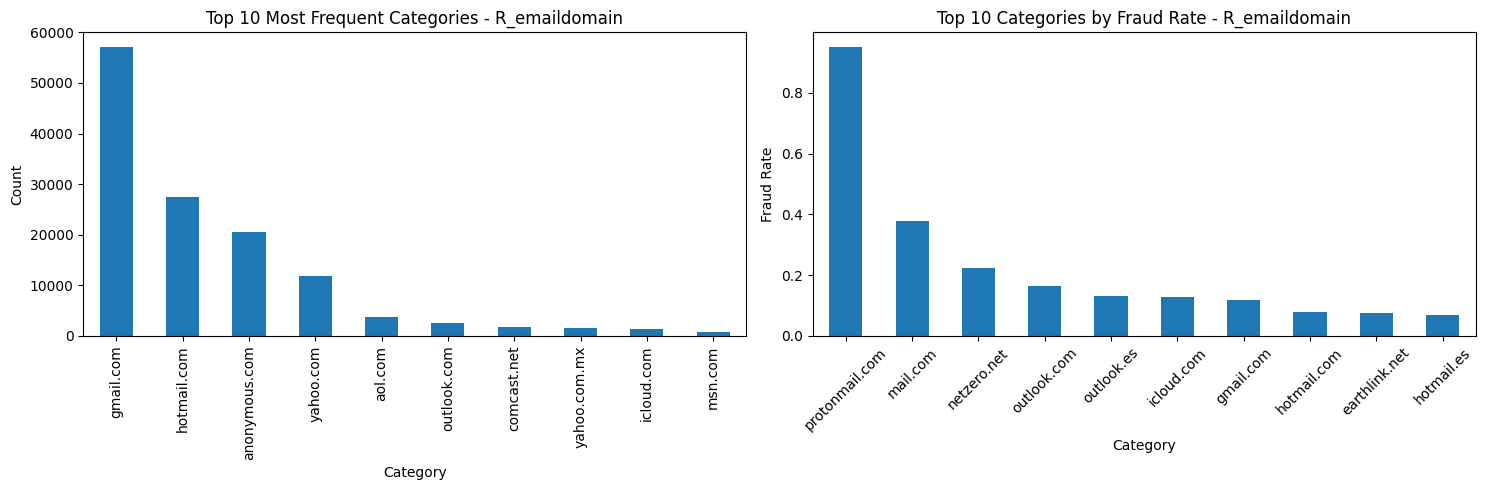


Analysis for R_emaildomain:
Number of unique values: 60
Missing values: 453249 (76.75%)

Top 5 categories by frequency:
R_emaildomain
gmail.com        57147
hotmail.com      27509
anonymous.com    20529
yahoo.com        11842
aol.com           3701

Top 5 categories by fraud rate (min 100 transactions):




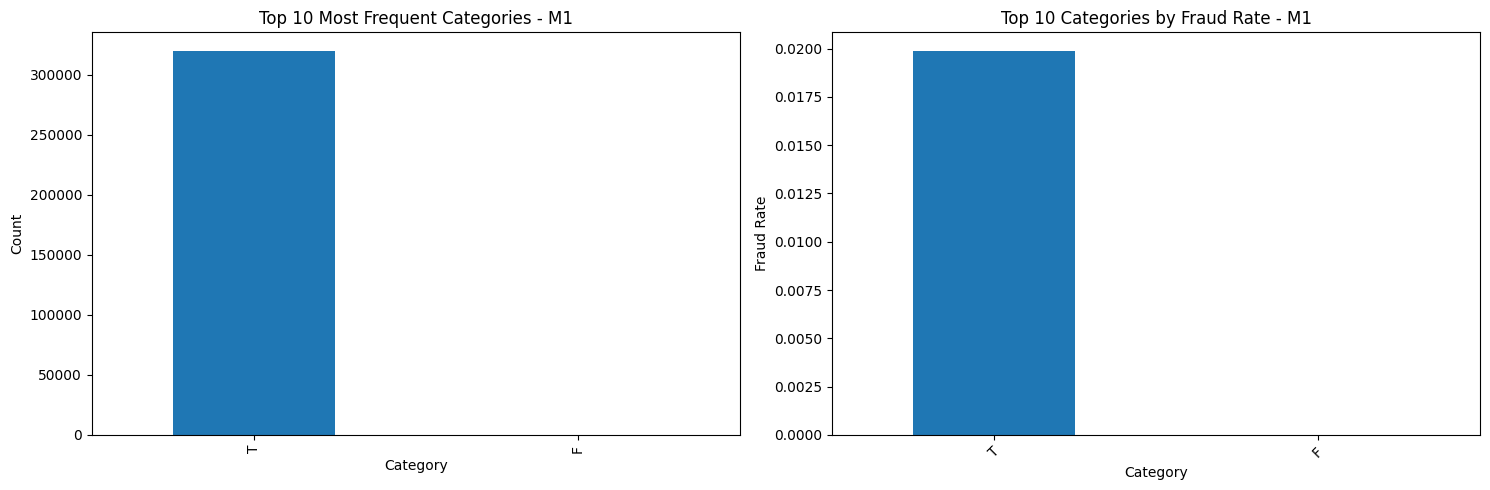


Analysis for M1:
Number of unique values: 2
Missing values: 271100 (45.91%)

Top 5 categories by frequency:
M1
T    319415
F        25

Top 5 categories by fraud rate (min 100 transactions):




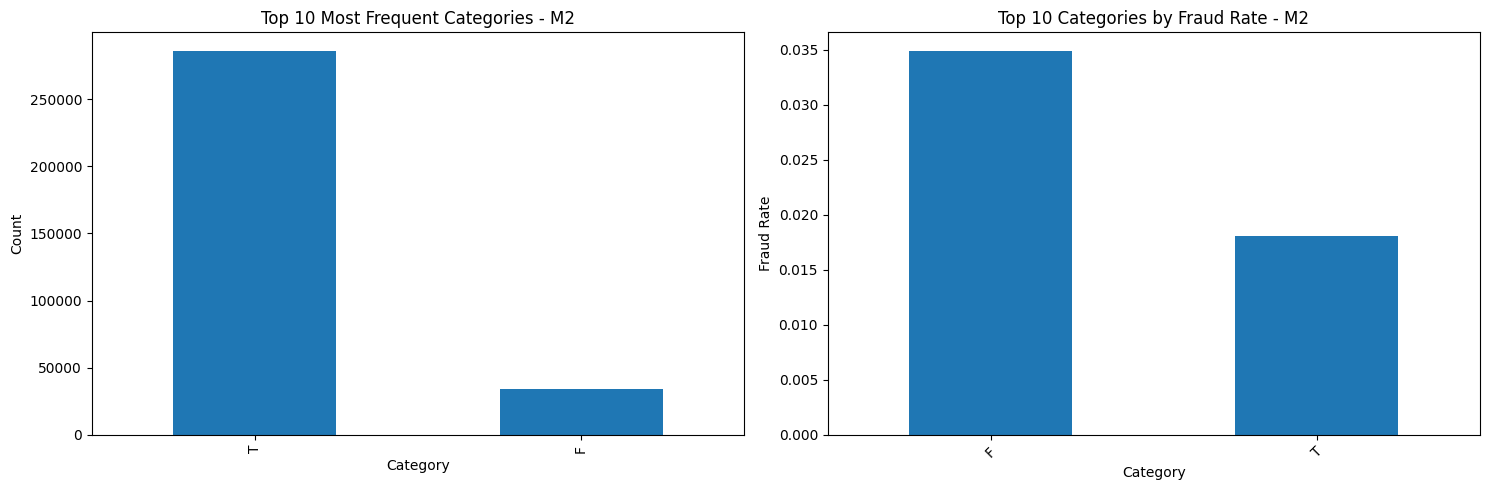


Analysis for M2:
Number of unique values: 2
Missing values: 271100 (45.91%)

Top 5 categories by frequency:
M2
T    285468
F     33972

Top 5 categories by fraud rate (min 100 transactions):




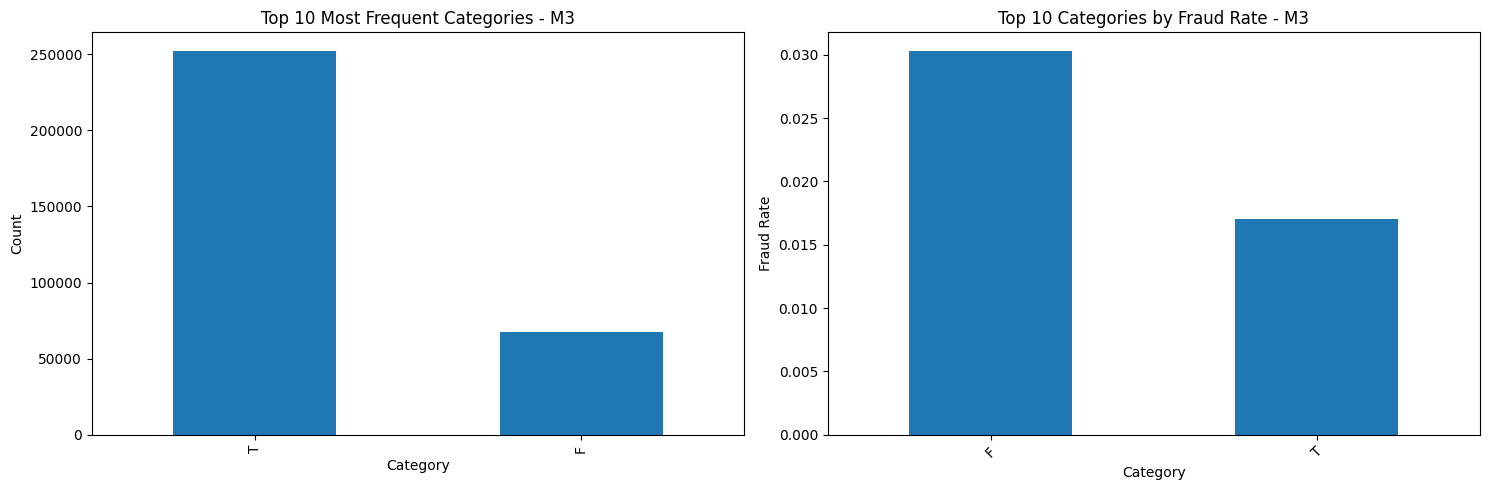


Analysis for M3:
Number of unique values: 2
Missing values: 271100 (45.91%)

Top 5 categories by frequency:
M3
T    251731
F     67709

Top 5 categories by fraud rate (min 100 transactions):




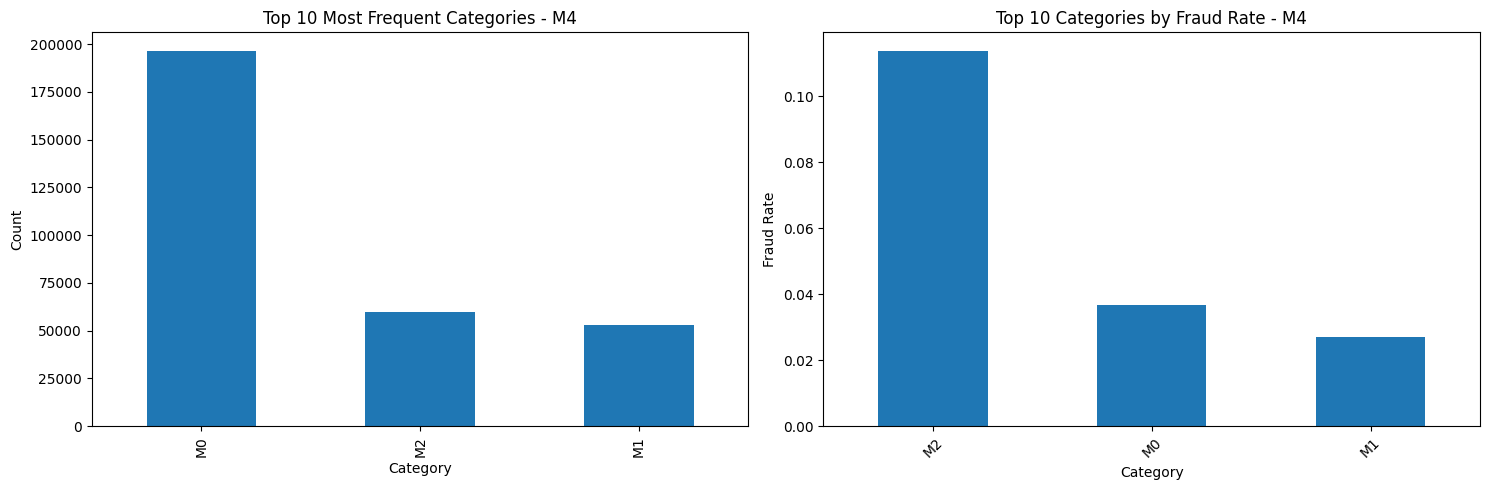


Analysis for M4:
Number of unique values: 3
Missing values: 281444 (47.66%)

Top 5 categories by frequency:
M4
M0    196405
M2     59865
M1     52826

Top 5 categories by fraud rate (min 100 transactions):




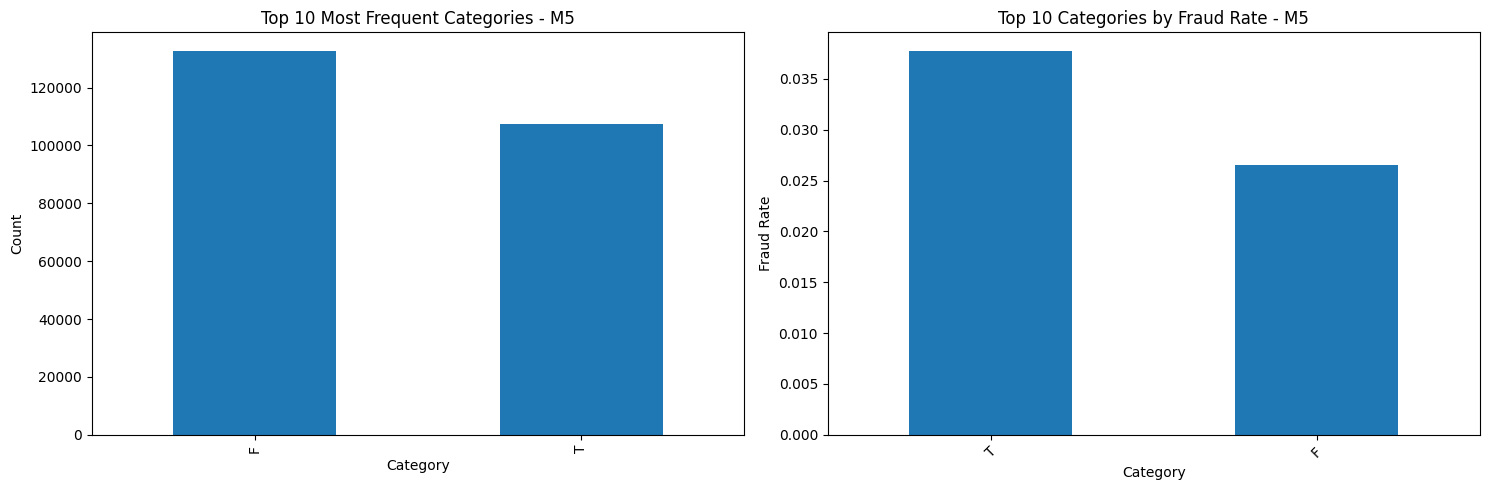


Analysis for M5:
Number of unique values: 2
Missing values: 350482 (59.35%)

Top 5 categories by frequency:
M5
F    132491
T    107567

Top 5 categories by fraud rate (min 100 transactions):




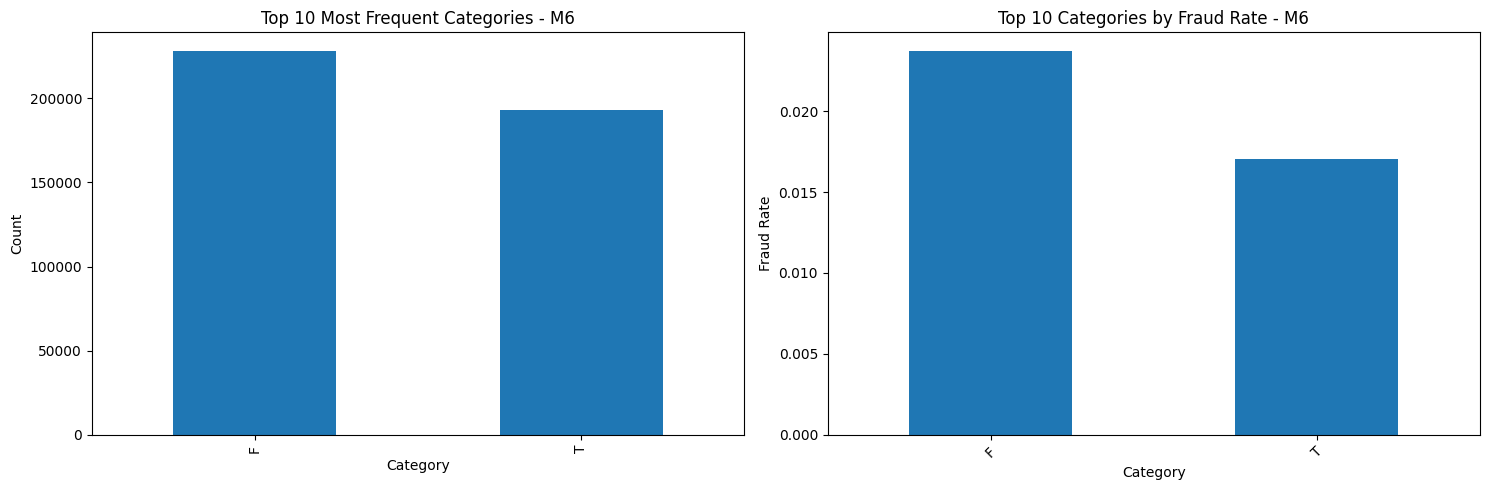


Analysis for M6:
Number of unique values: 2
Missing values: 169360 (28.68%)

Top 5 categories by frequency:
M6
F    227856
T    193324

Top 5 categories by fraud rate (min 100 transactions):




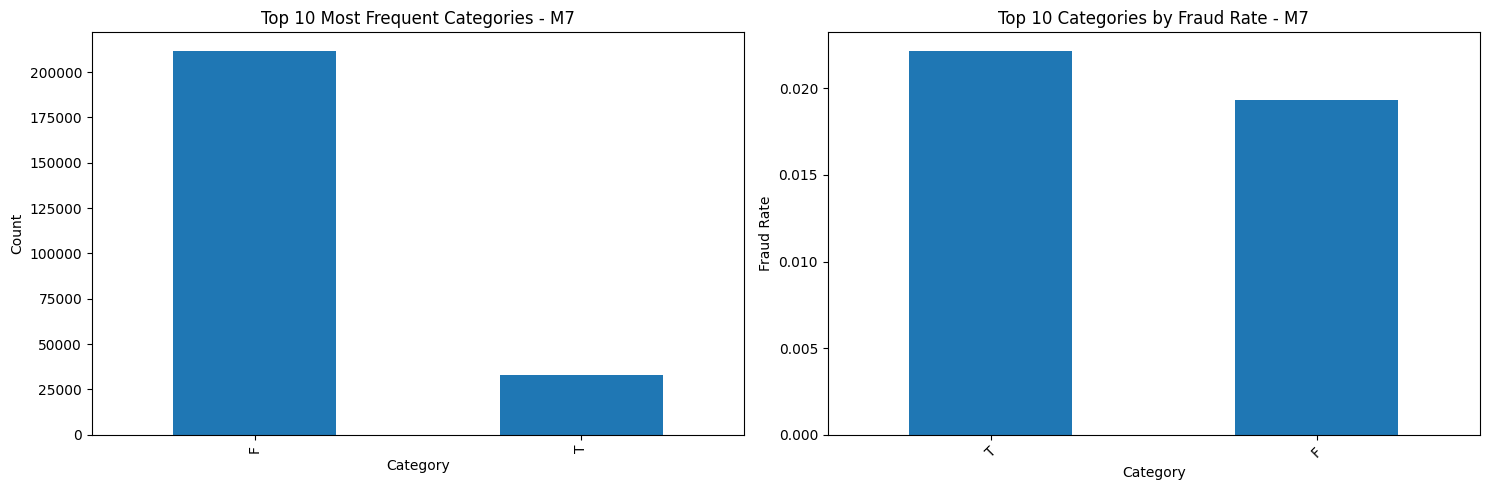


Analysis for M7:
Number of unique values: 2
Missing values: 346265 (58.64%)

Top 5 categories by frequency:
M7
F    211374
T     32901

Top 5 categories by fraud rate (min 100 transactions):




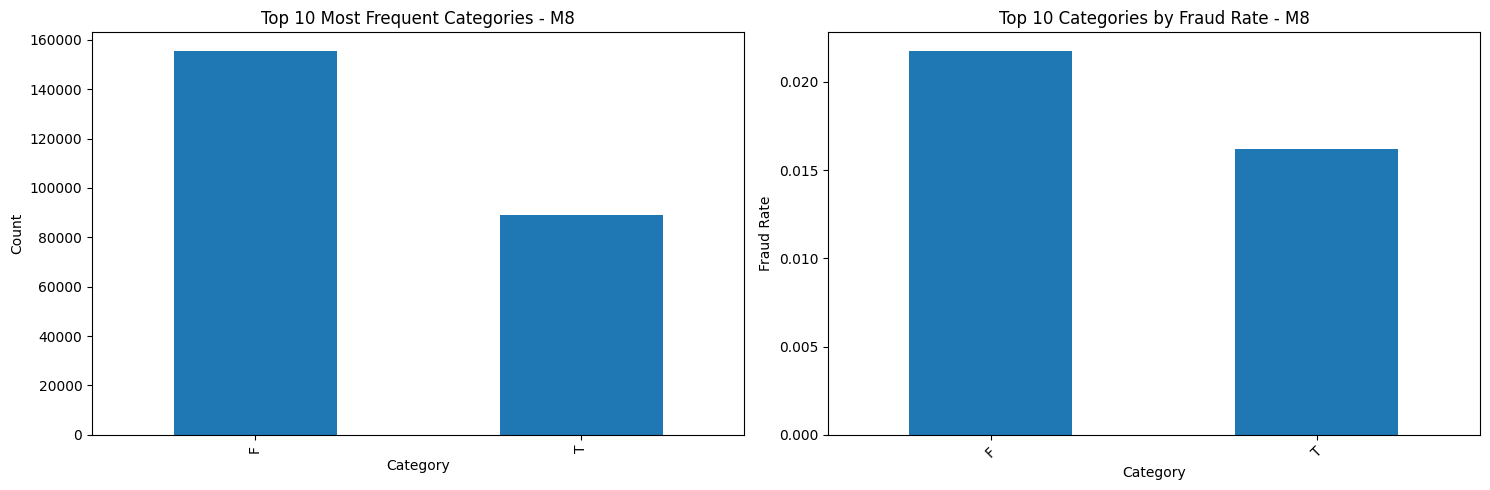


Analysis for M8:
Number of unique values: 2
Missing values: 346252 (58.63%)

Top 5 categories by frequency:
M8
F    155251
T     89037

Top 5 categories by fraud rate (min 100 transactions):




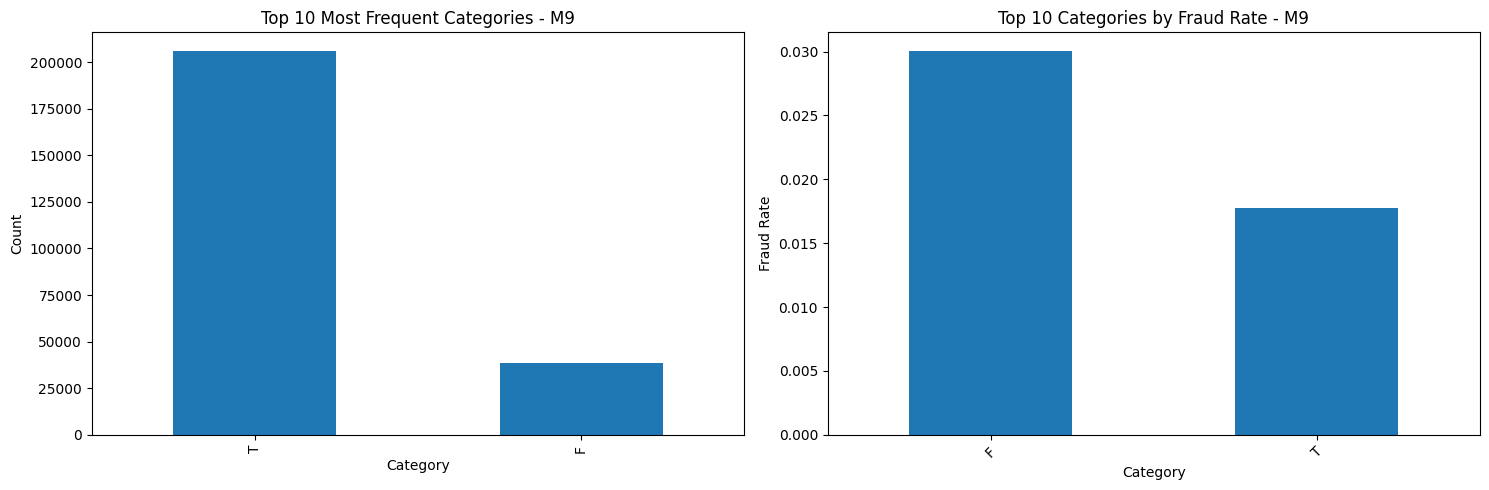


Analysis for M9:
Number of unique values: 2
Missing values: 346252 (58.63%)

Top 5 categories by frequency:
M9
T    205656
F     38632

Top 5 categories by fraud rate (min 100 transactions):




In [11]:
# List of categorical features to analyze
categorical_features = ['ProductCD'] + [f'card{i}' for i in range(1,7)] + ['addr1', 'addr2'] + \
                      ['P_emaildomain', 'R_emaildomain'] + [f'M{i}' for i in range(1,10)]

def analyze_categorical(feature):
    if feature not in train.columns:
        return None
    
    # Get value counts and fraud rates
    value_counts = train[feature].value_counts()
    fraud_rates = train.groupby(feature)['isFraud'].mean().sort_values(ascending=False)
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot 1: Top 10 most frequent categories
    value_counts.head(10).plot(kind='bar', ax=ax1)
    ax1.set_title(f'Top 10 Most Frequent Categories - {feature}')
    ax1.set_xlabel('Category')
    ax1.set_ylabel('Count')
    plt.xticks(rotation=45)
    
    # Plot 2: Fraud rate by category (top 10)
    fraud_rates.head(10).plot(kind='bar', ax=ax2)
    ax2.set_title(f'Top 10 Categories by Fraud Rate - {feature}')
    ax2.set_xlabel('Category')
    ax2.set_ylabel('Fraud Rate')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\nAnalysis for {feature}:")
    print(f"Number of unique values: {len(value_counts)}")
    print(f"Missing values: {train[feature].isnull().sum()} ({train[feature].isnull().mean():.2%})")
    print("\nTop 5 categories by frequency:")
    print(value_counts.head().to_string())
    print("\nTop 5 categories by fraud rate (min 100 transactions):")
    fraud_rates[value_counts[fraud_rates.index] >= 100].head().to_string()
    print("\n" + "="*50 + "\n")

# Analyze each categorical feature
for feature in categorical_features:
    analyze_categorical(feature)


## 7. Count & Time Features
- **C1–C14 (counts)**:
  - Distribution plots
  - Fraud rate by bins
- **D1–D15 (timedeltas)**:
  - Distributions
  - Missingness patterns
  - Possible time-based leakage check
- **M1–M9 (matches)**:
  - Count % True/False/NA
  - Fraud rate by match flag

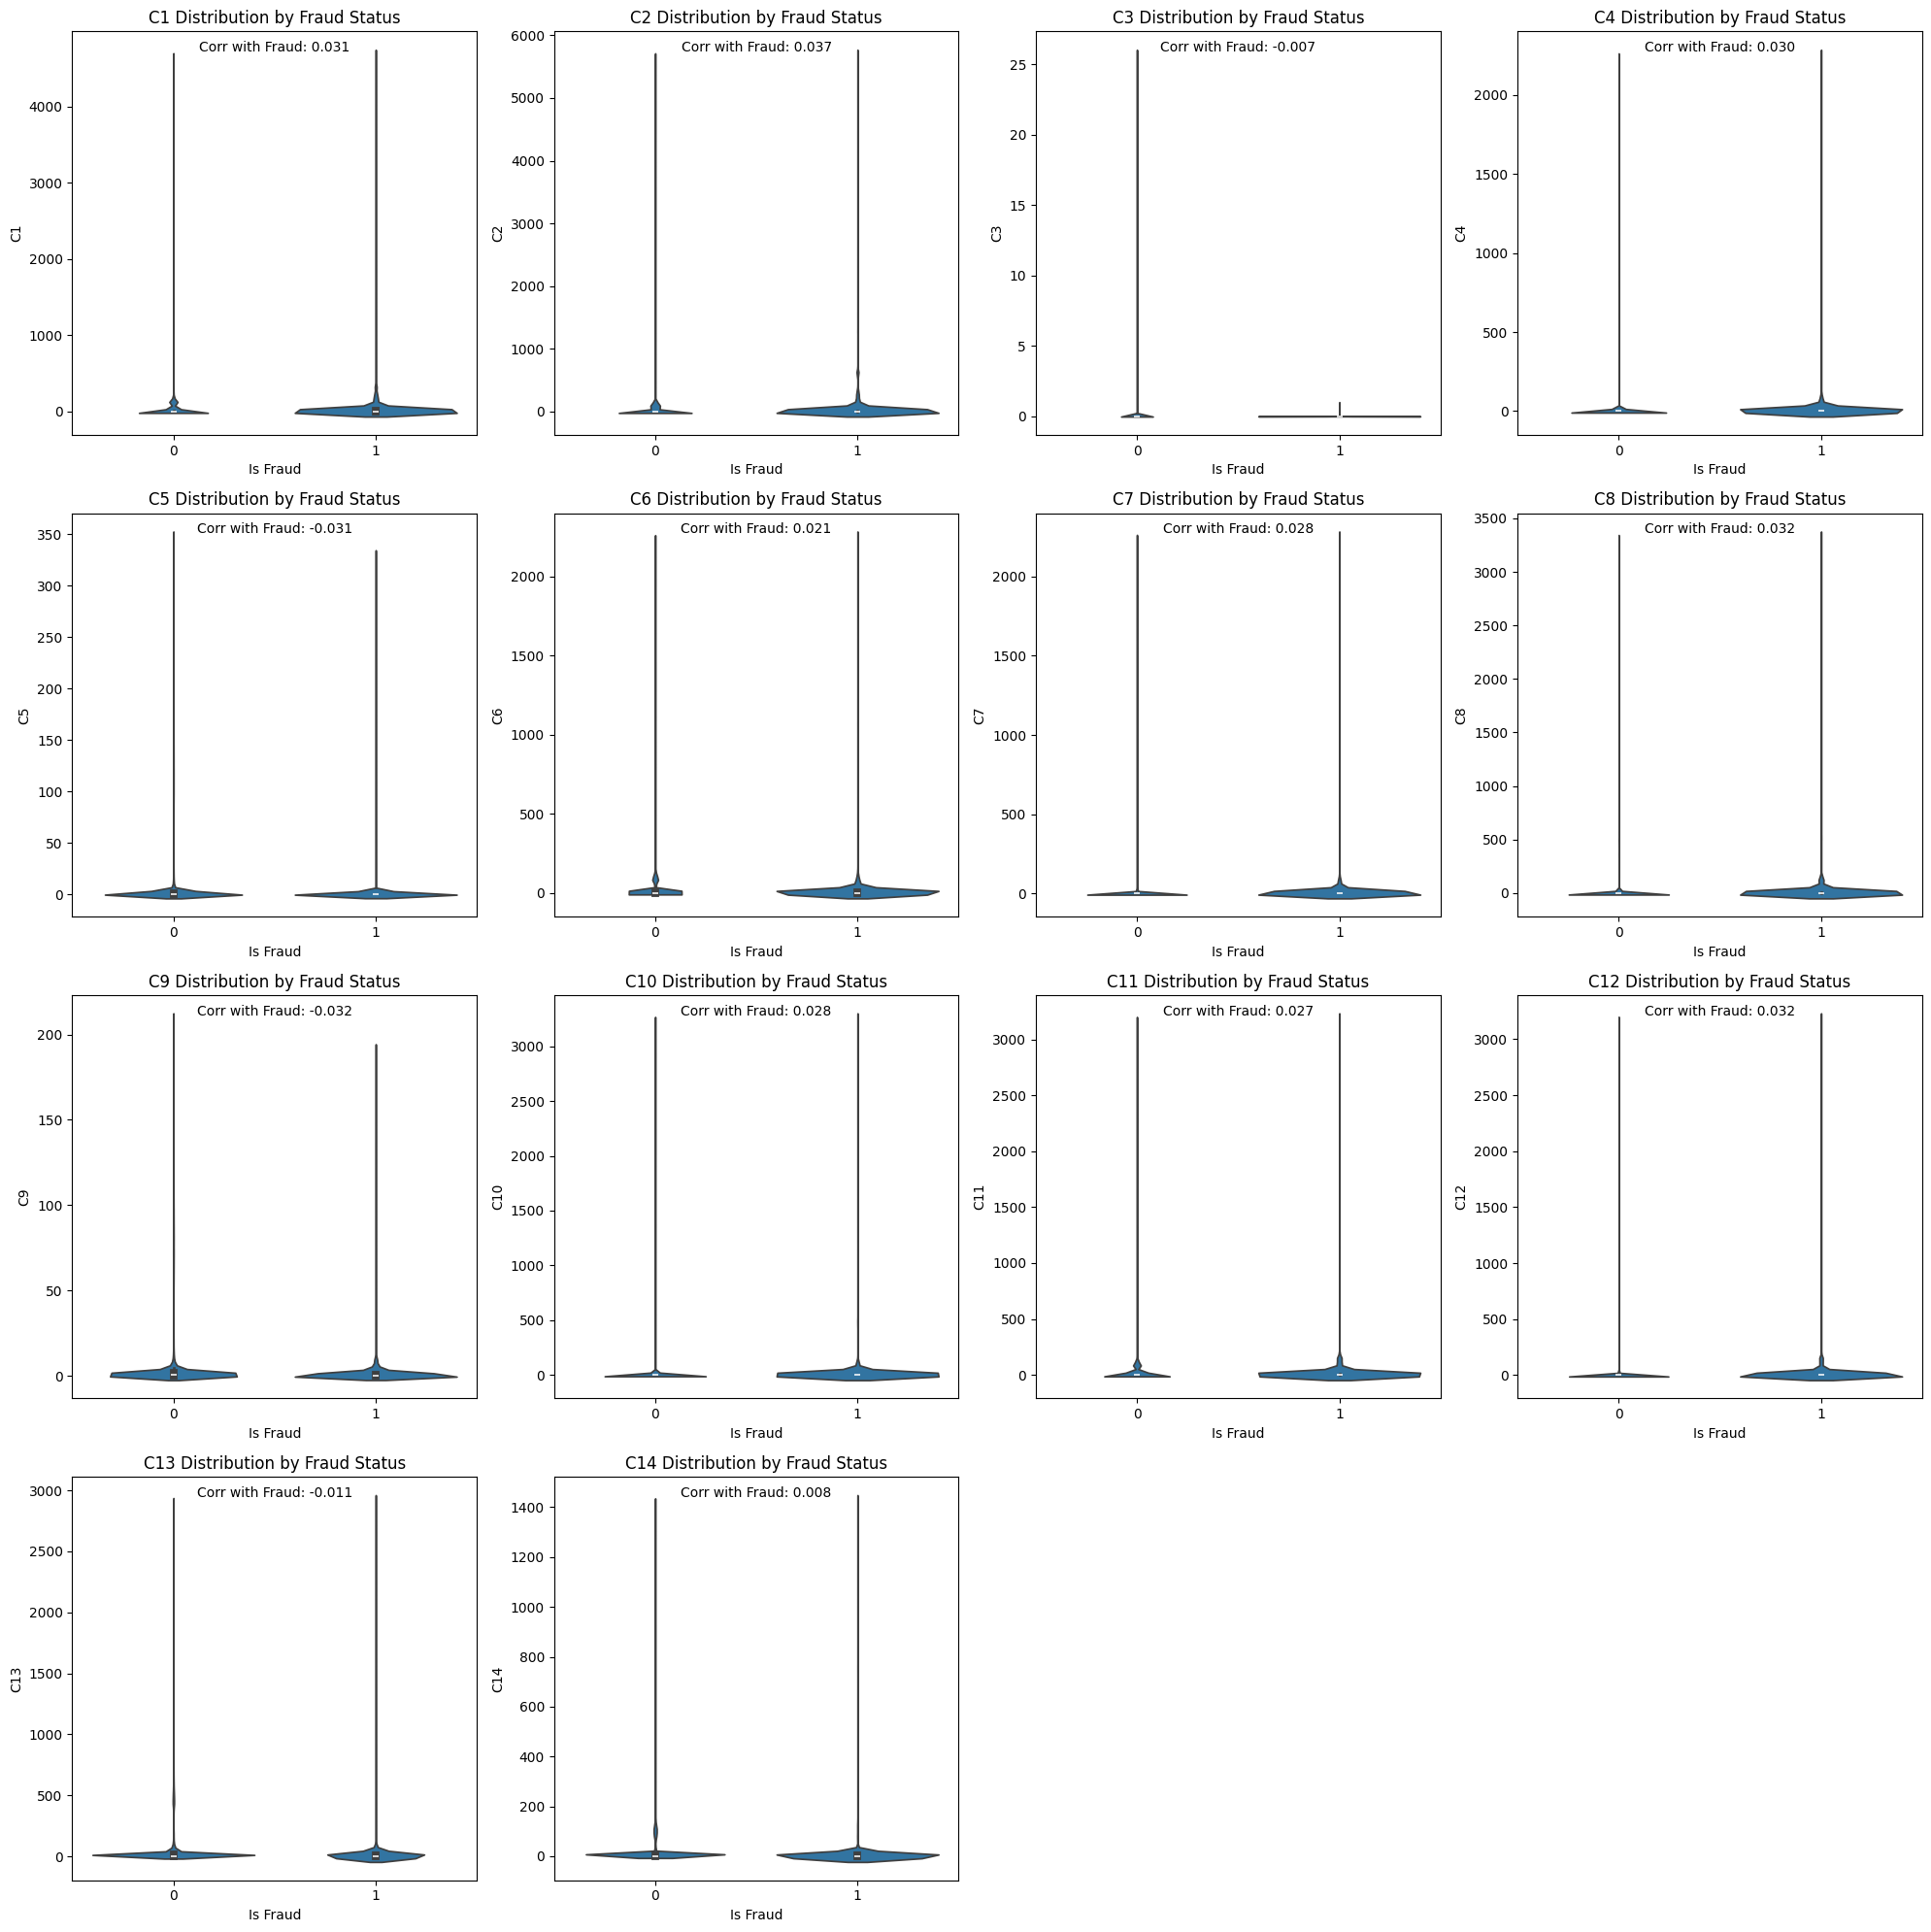


Count Features Statistics:

C1:
Missing values: 0 (0.00%)
Mean value: 14.09
Correlation with fraud: 0.031
Mean for non-fraud: 13.31
Mean for fraud: 35.54
----------------------------------------

C2:
Missing values: 0 (0.00%)
Mean value: 15.27
Correlation with fraud: 0.037
Mean for non-fraud: 14.17
Mean for fraud: 45.51
----------------------------------------

C3:
Missing values: 0 (0.00%)
Mean value: 0.01
Correlation with fraud: -0.007
Mean for non-fraud: 0.01
Mean for fraud: 0.00
----------------------------------------

C4:
Missing values: 0 (0.00%)
Mean value: 4.09
Correlation with fraud: 0.030
Mean for non-fraud: 3.69
Mean for fraud: 15.08
----------------------------------------

C5:
Missing values: 0 (0.00%)
Mean value: 5.57
Correlation with fraud: -0.031
Mean for non-fraud: 5.72
Mean for fraud: 1.41
----------------------------------------

C6:
Missing values: 0 (0.00%)
Mean value: 9.07
Correlation with fraud: 0.021
Mean for non-fraud: 8.79
Mean for fraud: 16.92
-------------

In [12]:
# Analyze count features (C1-C14)
count_features = [f'C{i}' for i in range(1, 15)]

# Create a figure for count features distribution
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
axes = axes.ravel()

# Plot distribution for each count feature
for idx, feature in enumerate(count_features):
    if feature in train.columns:
        # Create violin plot split by fraud status
        sns.violinplot(data=train, x='isFraud', y=feature, ax=axes[idx])
        axes[idx].set_title(f'{feature} Distribution by Fraud Status')
        axes[idx].set_xlabel('Is Fraud')
        
        # Calculate and display correlation with fraud
        correlation = train[[feature, 'isFraud']].corr().iloc[0,1]
        axes[idx].text(0.5, 0.95, f'Corr with Fraud: {correlation:.3f}', 
                      horizontalalignment='center', transform=axes[idx].transAxes)

# Remove empty subplots if any
for idx in range(len(count_features), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

# Print statistics for count features
print("\nCount Features Statistics:")
for feature in count_features:
    if feature in train.columns:
        print(f"\n{feature}:")
        print(f"Missing values: {train[feature].isnull().sum()} ({train[feature].isnull().mean():.2%})")
        print(f"Mean value: {train[feature].mean():.2f}")
        print(f"Correlation with fraud: {train[[feature, 'isFraud']].corr().iloc[0,1]:.3f}")
        
        # Calculate mean values for fraud vs non-fraud
        mean_by_fraud = train.groupby('isFraud')[feature].mean()
        print(f"Mean for non-fraud: {mean_by_fraud[0]:.2f}")
        print(f"Mean for fraud: {mean_by_fraud[1]:.2f}")
        print("-" * 40)


## 8. Vesta Engineered Features (Vxxx)
- Too many to explore individually
- Strategy:
  - Check correlation heatmap (Pearson, Spearman)
  - Variance threshold: drop low-variance features
  - PCA/UMAP for dimensionality reduction & visualization


In [3]:
# Select all Vesta engineered features (V1–V339)
v_features = [f'V{i}' for i in range(1, 340) if f'V{i}' in train.columns]
v_data = train[v_features]

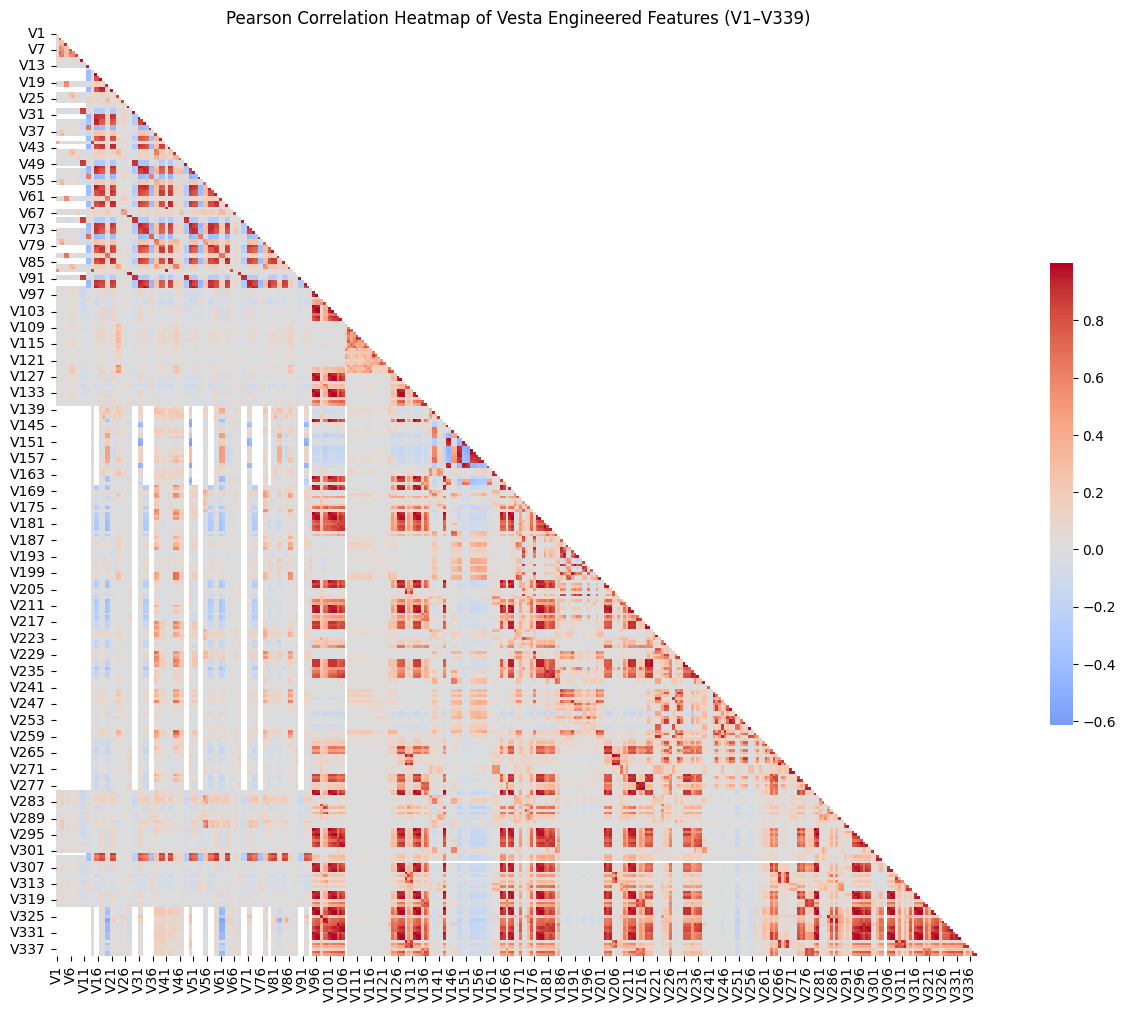

In [ ]:
# Compute Pearson and Spearman correlation matrices
pearson_corr = v_data.corr(method='pearson')

# Plot Pearson correlation heatmap (show only upper triangle for clarity)
plt.figure(figsize=(18, 12))
mask = np.triu(np.ones_like(pearson_corr, dtype=bool))
sns.heatmap(pearson_corr, mask=mask, cmap='coolwarm', center=0, square=True, cbar_kws={'shrink': .5}, linewidths=0)
plt.title('Pearson Correlation Heatmap of Vesta Engineered Features (V1–V339)')
plt.show()

In [26]:
# pca on V features
from sklearn.decomposition import PCA

v_data_clean = v_data.dropna(axis=1, how='all')  # Drop columns that are all NaN
#fill NaNs with mean of each column for PCA
v_data_clean = v_data_clean.fillna(v_data_clean.mean())

explained_variances = []
n_components_list = [200, 150, 100, 50, 40, 30, 25, 20, 15, 10, 5, 2, 1]
# try from 200 to 10 components to see explained variance ratio
for n_components in n_components_list:
    pca = PCA(n_components=n_components)
    pca.fit(v_data_clean)  # Fill NaNs with 0 for PCA
    e_var = np.sum(pca.explained_variance_ratio_)
    explained_variances.append(e_var)
    print(f'Number of components: {n_components}, Explained variance ratio: {e_var:.4f}')

Number of components: 200, Explained variance ratio: 1.0000
Number of components: 150, Explained variance ratio: 1.0000
Number of components: 100, Explained variance ratio: 1.0000
Number of components: 50, Explained variance ratio: 1.0000
Number of components: 40, Explained variance ratio: 1.0000
Number of components: 30, Explained variance ratio: 1.0000
Number of components: 25, Explained variance ratio: 0.9999
Number of components: 20, Explained variance ratio: 0.9999
Number of components: 15, Explained variance ratio: 0.9998
Number of components: 10, Explained variance ratio: 0.9993
Number of components: 5, Explained variance ratio: 0.9970
Number of components: 2, Explained variance ratio: 0.9927
Number of components: 1, Explained variance ratio: 0.9234


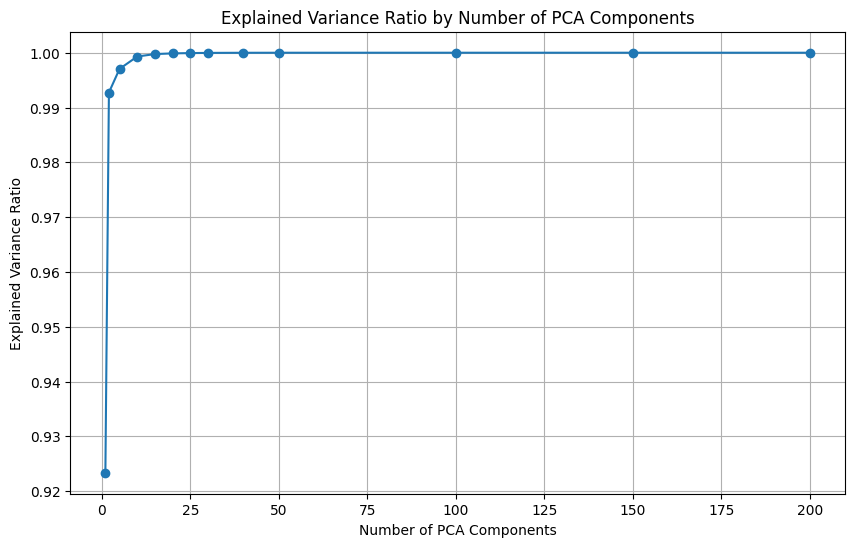

In [27]:
# Plot explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(n_components_list, explained_variances, marker='o')
plt.title('Explained Variance Ratio by Number of PCA Components')
plt.xlabel('Number of PCA Components')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()


## 9. Identity Features
- **DeviceType, DeviceInfo, id_12–id_38**
- Analyze distribution of devices (top 10 devices by frequency)
- Fraud rate by device type
- Missingness patterns (some devices recorded more often than others)


In [24]:
train_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


## 10. Feature Interactions (EDA Deep Dive)
- Fraud rate by (card1 + addr1)
- Fraud rate by (emaildomain + ProductCD)
- Fraud rate by (TransactionAMT + card4/card6)
- Time vs. TransactionAMT scatter plot (fraud vs non-fraud)

## 11. Correlation Analysis
- Numeric features: correlation matrix
- Check if any features are highly correlated (drop or combine)
- Fraud correlation heatmap (correlation with target)



## 12. Summary & Insights
- List most important EDA findings:
  - Strong fraud signals
  - Features with leakage risk
  - Features to drop (too missing/irrelevant)
  - Potential engineered features